In [1]:
# Add needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# VIF for multi-collinearity detection
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Models and modeling tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm

# Change inline plots default size
plt.rcParams['figure.figsize'] = [14, 10]

In [2]:
# Read in the rawData
rawData = pd.read_csv('term-deposit-marketing-2020.csv')

# Separate data in independent (features) and dependent (target) datasets
features = rawData.copy()
target = features.pop('y')

# Replace binary columns 1/0
for col in ['default', 'housing', 'loan']:
    features[col].replace({'yes':1,'no':0}, inplace=True)

############################################################################################################################### \
############################################################################################################################### \
############################################################################################################################### 

## Exploratory Data Analysis

In [3]:
# Initial descriptive statistics investigation into the dataset
rawData.describe()

age        balance           day      duration      campaign
count  40000.000000   40000.000000  40000.000000  40000.000000  40000.000000
mean      40.544600    1274.277550     16.017225    254.824300      2.882175
std        9.641776    2903.769716      8.278127    259.366498      3.239051
min       19.000000   -8019.000000      1.000000      0.000000      1.000000
25%       33.000000      54.000000      8.000000    100.000000      1.000000
50%       39.000000     407.000000     17.000000    175.000000      2.000000
75%       48.000000    1319.000000     21.000000    313.000000      3.000000
max       95.000000  102127.000000     31.000000   4918.000000     63.000000

In [4]:
# Check for missing data
rawData.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

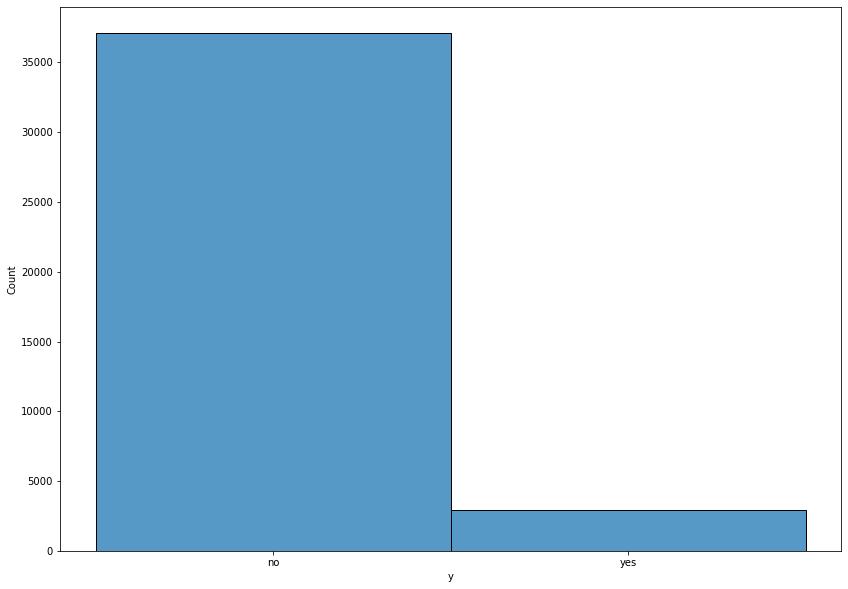

no     0.9276
yes    0.0724
Name: y, dtype: float64

In [5]:
# Plot response variable
fig, axs = plt.subplots()
sns.histplot(data=rawData, x='y',discrete=True)
plt.show()

# Get unbalanced ratios
target.value_counts() / target.count()

### Initial description: 
- N=40000 datapoints, 
- Response Variable (Y) is binary 
- Predictors are a mix of categorical and numerical
- No missing data
- Response variable very unbalanced (92.76% / 7.24%)

- This is consistent with the data descriptions provided:

```
Data Description:

age: age of customer (numeric)
job: type of job (categorical)
marital: marital status (categorical)
education: education (categorical)
default: has credit in default? (binary)
balance: average yearly balance, in euros (numeric)
housing: has a housing loan? (binary)
loan: has personal loan? (binary)
contact: contact communication type (categorical)
day: last contact day of the month (numeric)
month: last contact month of year (categorical)
duration: last contact duration, in seconds (numeric)
campaign: # of contacts performed during this campaign and for this client (numeric, includes last contact)

y - has the client subscribed to a term deposit? (binary)

```

### Initial thoughts: 
- __Unbalanced Binary response variable__ 
    - Oversampling/Undersampling, SMOTE, Penalized methods (https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/), 
- __Mix of categorical and quantitative__ 
    - Will need to encode the categorical variables and assess the quantitative ones for normalization/scaling


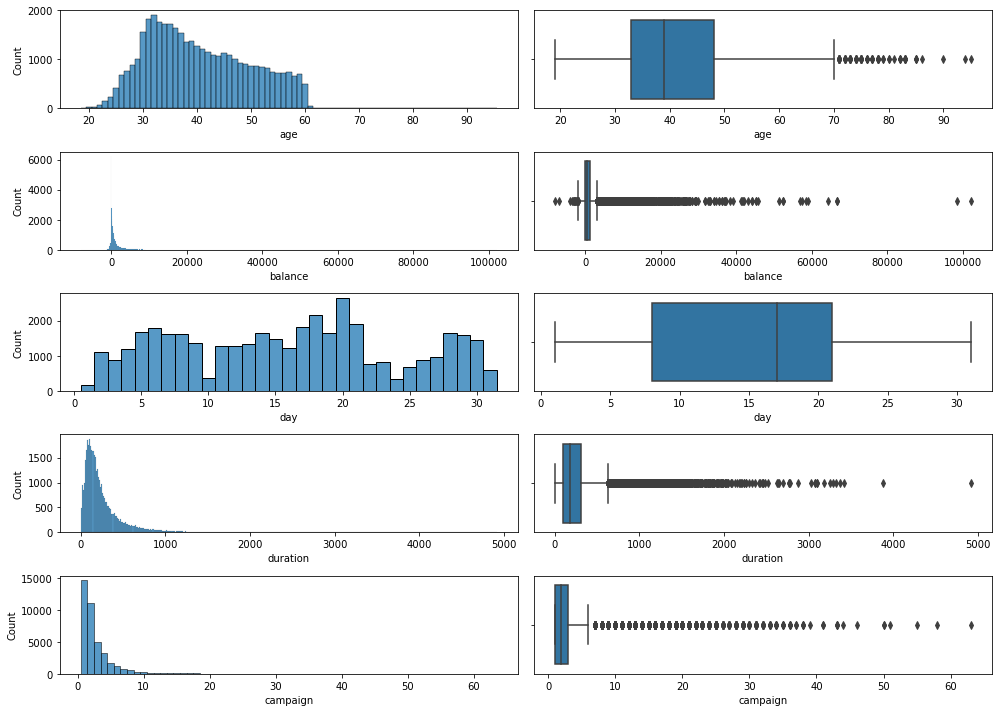

In [6]:
# Plot the feature distributions to look for skewed data/visualize possible outliers
intCols = np.where(features.dtypes == 'int64')

fig, axs = plt.subplots(np.size(intCols),2)
cnt = 0
for colID in intCols[0]:
    rnge = features[features.columns[colID]].max() - features[features.columns[colID]].min()
    if (rnge < 100):
        sns.histplot(data=features, x=features.columns[colID], ax=axs[cnt,0], discrete=True)
    else:
        sns.histplot(data=features, x=features.columns[colID], ax=axs[cnt,0])
    sns.boxplot(data=features, x=features.columns[colID], ax=axs[cnt,1])
    cnt = cnt + 1

plt.tight_layout()
plt.show()

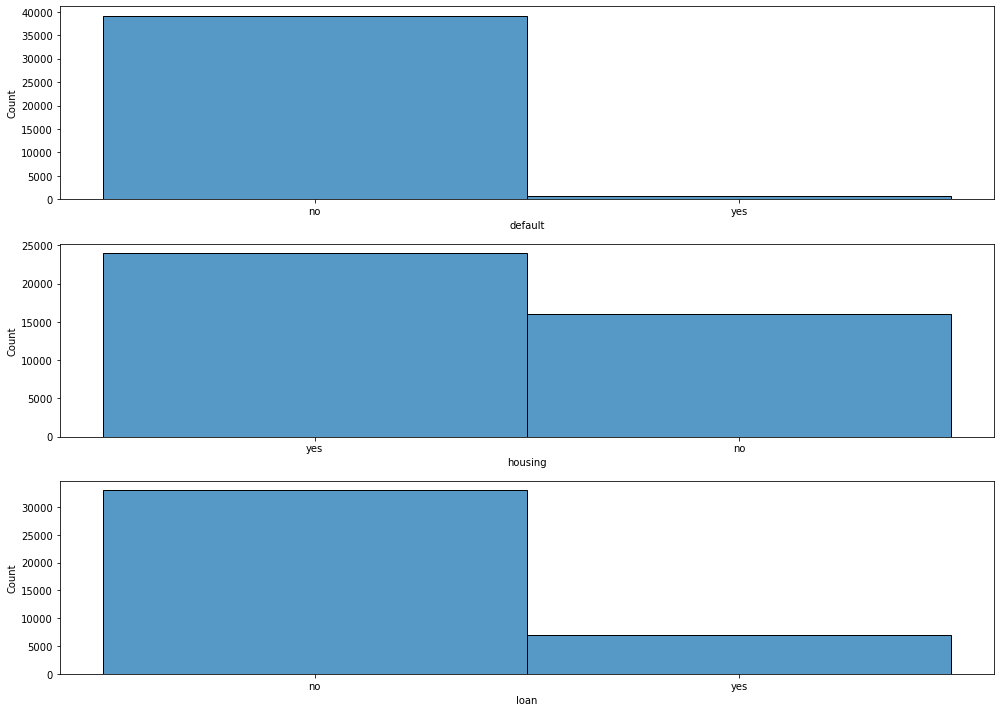

In [7]:
# Plot the feature distributions to look for skewed data/visualize possible outliers
cols = ['default', 'housing', 'loan']

fig, axs = plt.subplots(np.size(cols),1)
cnt = 0
for col in cols:
    sns.histplot(data=features, x=col, ax=axs[cnt], discrete=True)
    cnt = cnt + 1

plt.tight_layout()
plt.show()

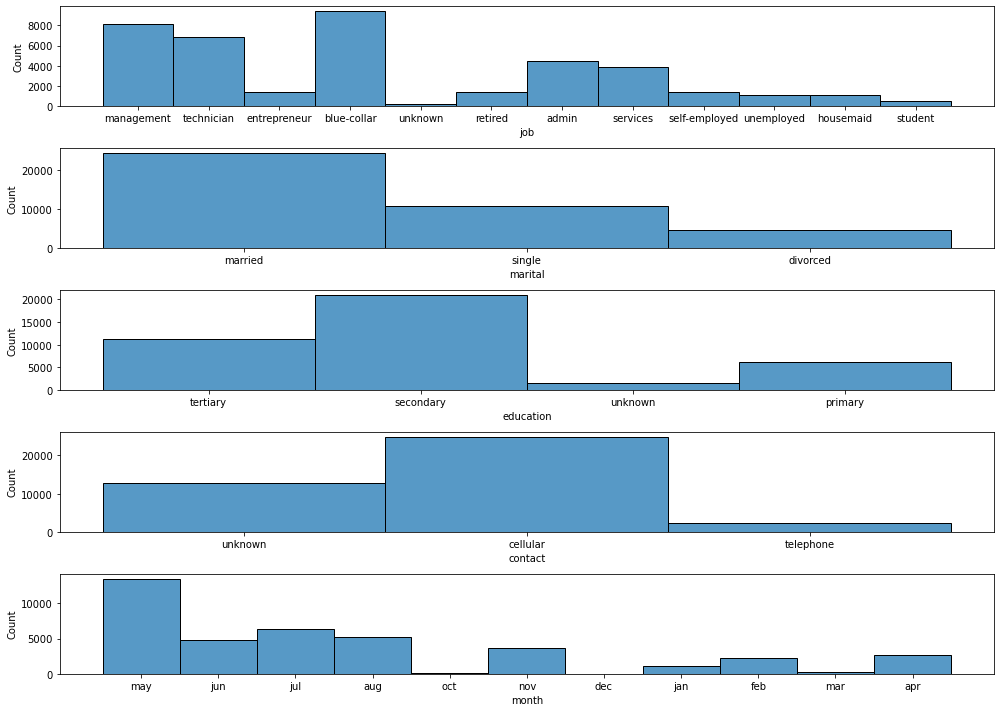

In [8]:
# Plot the feature distributions to look for skewed data/visualize possible outliers
cols = ['job', 'marital', 'education', 'contact', 'month']

fig, axs = plt.subplots(np.size(cols),1)
cnt = 0
for col in cols:
    sns.histplot(data=features, x=col, ax=axs[cnt], discrete=True)
    cnt = cnt + 1

plt.tight_layout()
plt.show()

In [9]:
features.skew()

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


age         0.436080
balance     8.259236
day         0.067930
duration    3.165307
campaign    4.730901
dtype: float64

In [10]:
features.corr()

age   balance       day  duration  campaign
age       1.000000  0.081517 -0.011689 -0.036270  0.016204
balance   0.081517  1.000000  0.011662  0.014072 -0.008137
day      -0.011689  0.011662  1.000000 -0.032983  0.165429
duration -0.036270  0.014072 -0.032983  1.000000 -0.088387
campaign  0.016204 -0.008137  0.165429 -0.088387  1.000000

In [11]:
# Generate VIF factors for each feature
cols = ['age', 'balance', 'day', 'duration', 'campaign']

vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = features[cols].columns 
  
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(features[cols].values, i) for i in range(len(features[cols].columns))] 
  
display(vif_scores)

Attribute  VIF Scores
0       age    4.975994
1   balance    1.201092
2       day    4.162652
3  duration    1.858026
4  campaign    1.828352

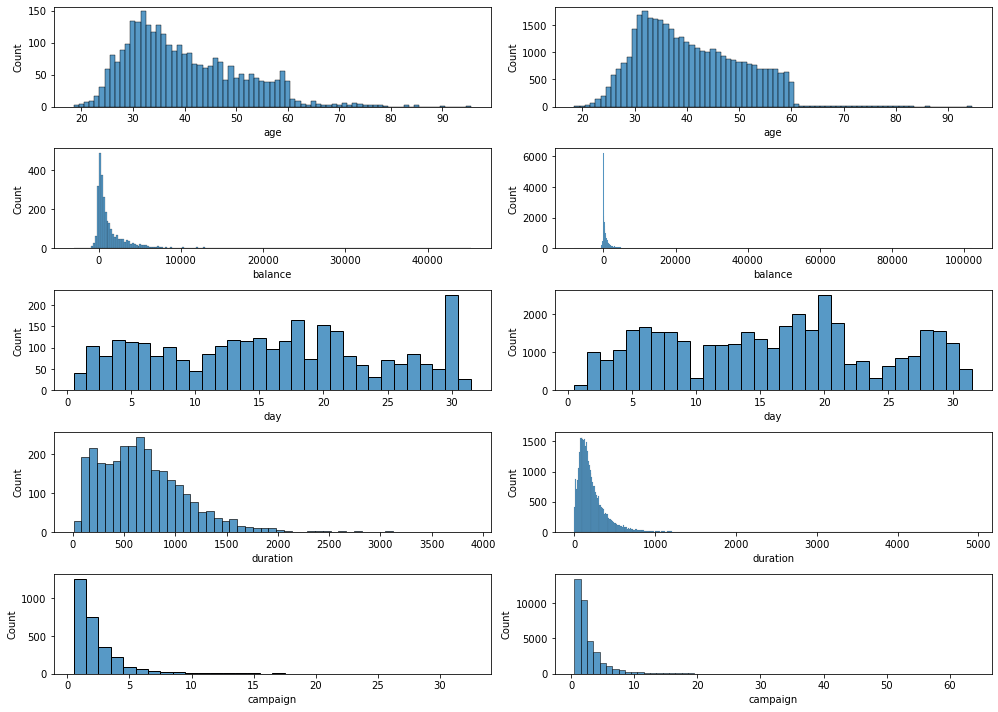

In [12]:
# Look at distributions against yes/no
yes = rawData.loc[rawData.y == 'yes']
no = rawData.loc[rawData.y == 'no']

intCols = np.where(features.dtypes == 'int64')

fig, axs = plt.subplots(np.size(intCols),2)
cnt = 0
for colID in intCols[0]:
    rnge = features[features.columns[colID]].max() - features[features.columns[colID]].min()
    if (rnge < 100):
        sns.histplot(data=yes, x=features.columns[colID], ax=axs[cnt,0], discrete=True)
        sns.histplot(data=no, x=features.columns[colID], ax=axs[cnt,1], discrete=True)
    else:
        sns.histplot(data=yes, x=features.columns[colID], ax=axs[cnt,0])
        sns.histplot(data=no, x=features.columns[colID], ax=axs[cnt,1])

    cnt = cnt + 1

plt.tight_layout()
plt.show()

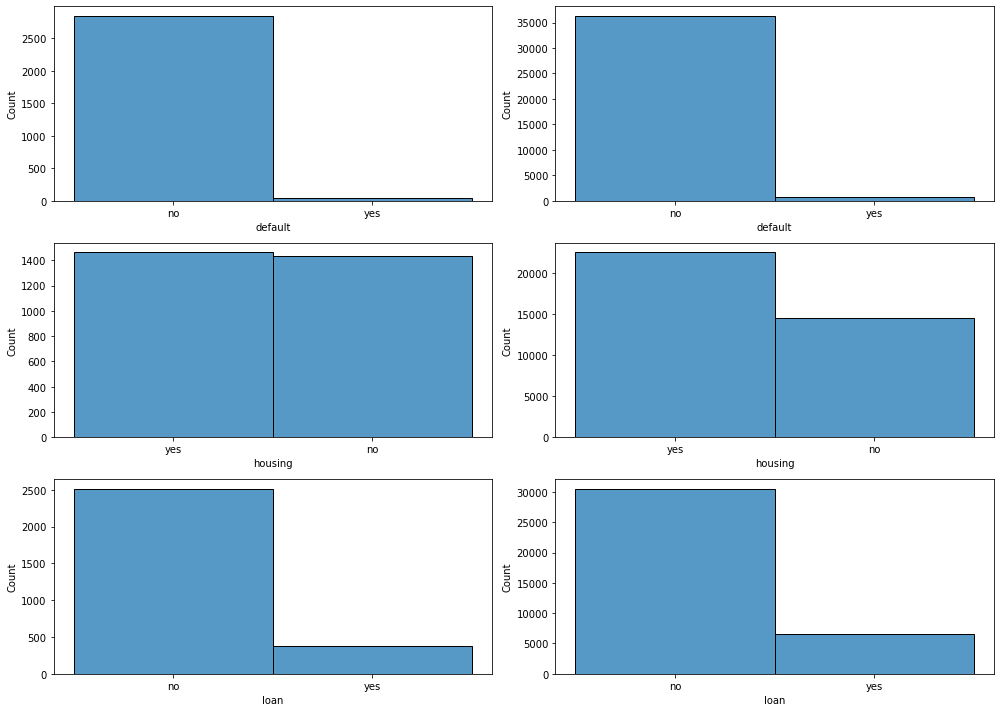

In [13]:
# Look at distributions against yes/no
yes = rawData.loc[rawData.y == 'yes']
no = rawData.loc[rawData.y == 'no']

# Plot the feature distributions to look for skewed data/visualize possible outliers
cols = ['default', 'housing', 'loan']

fig, axs = plt.subplots(np.size(cols),2)
cnt = 0
for col in cols:
    sns.histplot(data=yes, x=col, ax=axs[cnt,0], discrete=True)
    sns.histplot(data=no, x=col, ax=axs[cnt,1], discrete=True)
    cnt = cnt + 1

plt.tight_layout()
plt.show()

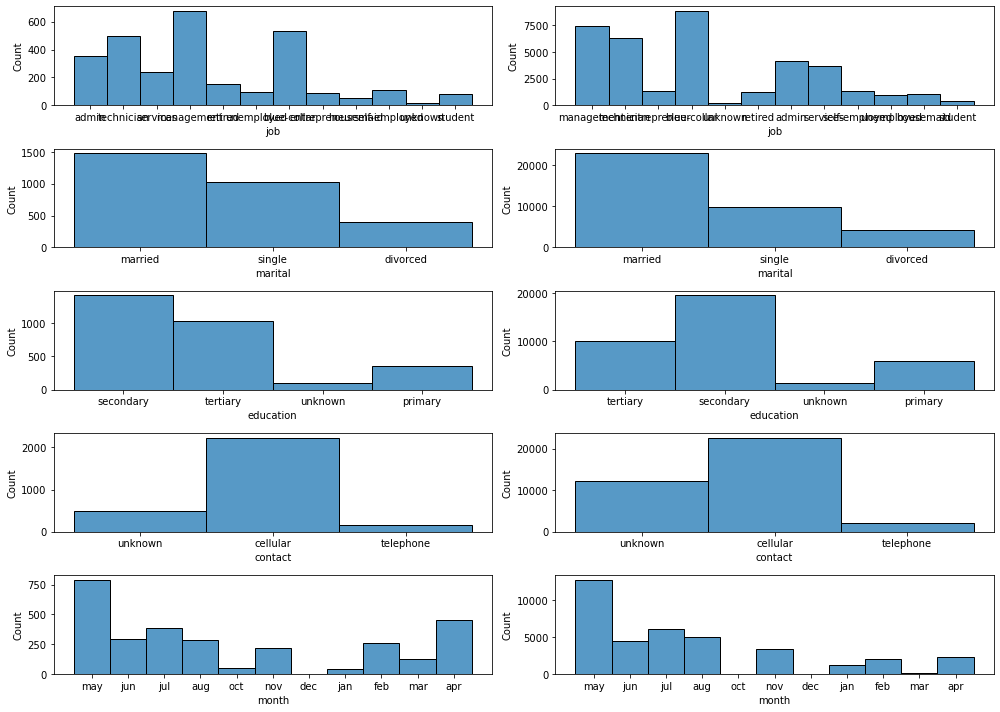

In [14]:
# Look at distributions against yes/no
yes = rawData.loc[rawData.y == 'yes']
no = rawData.loc[rawData.y == 'no']

# Plot the feature distributions to look for skewed data/visualize possible outliers
cols = ['job', 'marital', 'education', 'contact', 'month']

fig, axs = plt.subplots(np.size(cols),2)
cnt = 0
for col in cols:
    sns.histplot(data=yes, x=col, ax=axs[cnt,0], discrete=True)
    sns.histplot(data=no, x=col, ax=axs[cnt,1], discrete=True)
    cnt = cnt + 1

plt.tight_layout()
plt.show()

In [15]:
from sklearn.feature_selection import mutual_info_classif

cols = ['age', 'balance', 'day', 'duration', 'campaign']

def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y, discrete_features=True)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(features[cols], target)
display (mi_scores)

duration    0.100265
balance     0.074362
age         0.004800
day         0.004773
campaign    0.001566
Name: MI Scores, dtype: float64

In [33]:
enc = OneHotEncoder(drop='if_binary', sparse=False)
encoded = enc.fit_transform(features[['default', 'housing', 'loan']])
features.drop(['default', 'housing', 'loan'])
pd.concat(features,)

In [34]:
pd.DataFrame(encoded)

0    1    2
0      0.0  1.0  0.0
1      0.0  1.0  0.0
2      0.0  1.0  1.0
3      0.0  1.0  0.0
4      0.0  0.0  0.0
...    ...  ...  ...
39995  0.0  0.0  0.0
39996  0.0  0.0  0.0
39997  0.0  0.0  0.0
39998  0.0  0.0  0.0
39999  0.0  1.0  0.0

[40000 rows x 3 columns]

In [ ]:
pd.Series(np.where(sample.housing.values == 'yes', 1, 0),
          sample.index)

In [43]:
for col in ['default', 'housing', 'loan']:
    features[col].replace({'yes':1,'no':0}, inplace=True)

In [44]:
features

age           job   marital  education  default  balance  housing  \
0       58    management   married   tertiary        0     2143        1   
1       44    technician    single  secondary        0       29        1   
2       33  entrepreneur   married  secondary        0        2        1   
3       47   blue-collar   married    unknown        0     1506        1   
4       33       unknown    single    unknown        0        1        0   
...    ...           ...       ...        ...      ...      ...      ...   
39995   53    technician   married   tertiary        0      395        0   
39996   30    management    single   tertiary        0     3340        0   
39997   54         admin  divorced  secondary        0      200        0   
39998   34    management   married   tertiary        0     1047        0   
39999   38    technician   married  secondary        0     1442        1   

       loan   contact  day month  duration  campaign  
0         0   unknown    5   may       261         1  
1         0   unknown    5   may       151         1  
2         1   unknown    5   may        76         1  
3         0   unknown    5   may        92         1  
4         0   unknown    5   may       198         1  
...     ...       ...  ...   ...       ...       ...  
39995     0  cellular    3   jun       107         1  
39996     0  cellular    3   jun       238         3  
39997     0  cellular    3   jun       170         1  
39998     0  cellular    3   jun       342         1  
39999     0  cellular    3   jun       113         1  

[40000 rows x 13 columns]

In [ ]:
### Try PCA
### XgBoost, KNN, SVM, RandomForest, NaiveBayes, LogisticRegression, AUC/Accuracy comparison values
### Start here: NaiveBayes, LogisticRegression
### KNN which k is best?
### SVM which hyperplane is best?   Enough RAM!